# MNIST classification using Radial Basis Function Network 

Some optimal weights before training


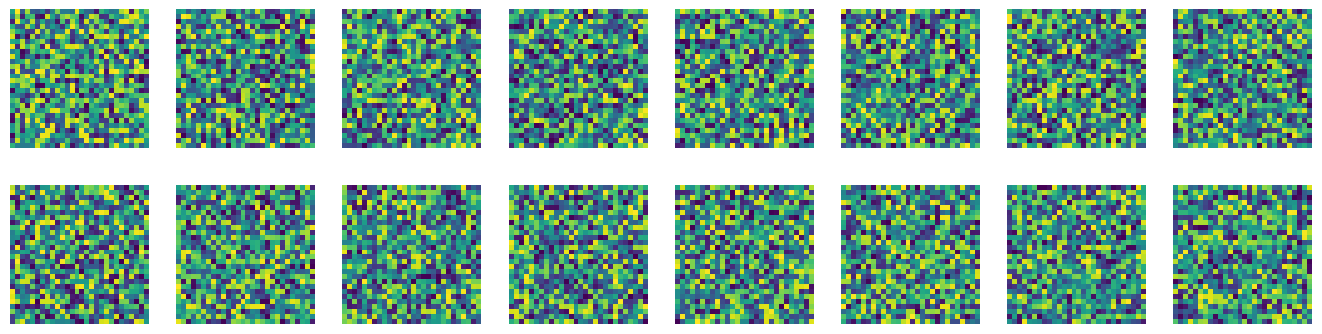

Epoch [1/2], Step [100/600], Loss: 2.2811
Epoch [1/2], Step [200/600], Loss: 2.1622
Epoch [1/2], Step [300/600], Loss: 1.7865
Epoch [1/2], Step [400/600], Loss: 1.3243
Epoch [1/2], Step [500/600], Loss: 1.2738
Epoch [1/2], Step [600/600], Loss: 1.1266
Epoch [2/2], Step [100/600], Loss: 0.8795
Epoch [2/2], Step [200/600], Loss: 0.9259
Epoch [2/2], Step [300/600], Loss: 0.7981
Epoch [2/2], Step [400/600], Loss: 0.7583
Epoch [2/2], Step [500/600], Loss: 0.7160
Epoch [2/2], Step [600/600], Loss: 0.7171
Accuracy of the network on the 10000 test images: 85.91 %


In [10]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters
input_size = 784 # 28x28
hidden_size = 60
num_classes = 10
num_epochs = 2
batch_size = 100
learning_rate = 0.002

# MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='./data',
                                           train=True,
                                           transform=transforms.ToTensor(),
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='./data',
                                          train=False,
                                          transform=transforms.ToTensor())

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

class Gaussian(nn.Module):
    def __init__(self, input_size, output_size):
        super(Gaussian, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        torch.manual_seed(102)
        self.weights = nn.Parameter(2*(torch.rand(self.output_size, self.input_size)-0.5))



    def forward(self, x):
        W = self.weights
        n, dw = W.shape
        m, dx = x.shape 
        assert dw==dx
        x_reshaped = x.view(m, 1, dx)
        W_reshaped = W.view(1, n, dw)
        dist = (x_reshaped - W_reshaped).norm(dim=2)
        w = 6 # = 75% * torch.abs(dist).max()
        gauss = torch.exp(-dist**2/w**2)
        return gauss

# Fully connected neural network with one hidden layer
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.input_size = input_size
        self.l1 = Gaussian(input_size, hidden_size)
        self.l2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.l1(x)
        out = self.l2(out)
        # no activation and no softmax at the end
        return out

model = NeuralNet(input_size, hidden_size, num_classes).to(device)

# plot initial weights
model_state_dict = model.state_dict()
W = model_state_dict['l1.weights']

def plot_weights(weights, nrows=2, ncols=8, suptitle=None, predictions=None):
    # print(predictions)
    np.random.seed(103)
    n_images = nrows * ncols
    indices = np.random.choice(range(weights.shape[0]), n_images).reshape(nrows, ncols)
    fig, axs = plt.subplots(nrows, ncols, figsize=(ncols*2.1, nrows*2.1))
    
    for i in range(nrows):
        for j in range(ncols):
            ax = axs[i, j]
            ax.imshow(weights[indices[i, j]].reshape(28, 28))
            if predictions is  not None:
                ax.set_title(str(predictions[indices[i, j]]))
            ax.axis("off")
    fig.suptitle(suptitle)
    plt.show()

print("Some optimal weights before training")
plot_weights(weights=W, nrows=2, ncols=8)


# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # origin shape: [100, 1, 28, 28]
        # resized: [100, 784]
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for images, labels in test_loader:
        flat_images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        outputs = model(flat_images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs.data, 1)
        # predicted = predicted.numpy()
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network on the 10000 test images: {acc} %')


Some weights after training


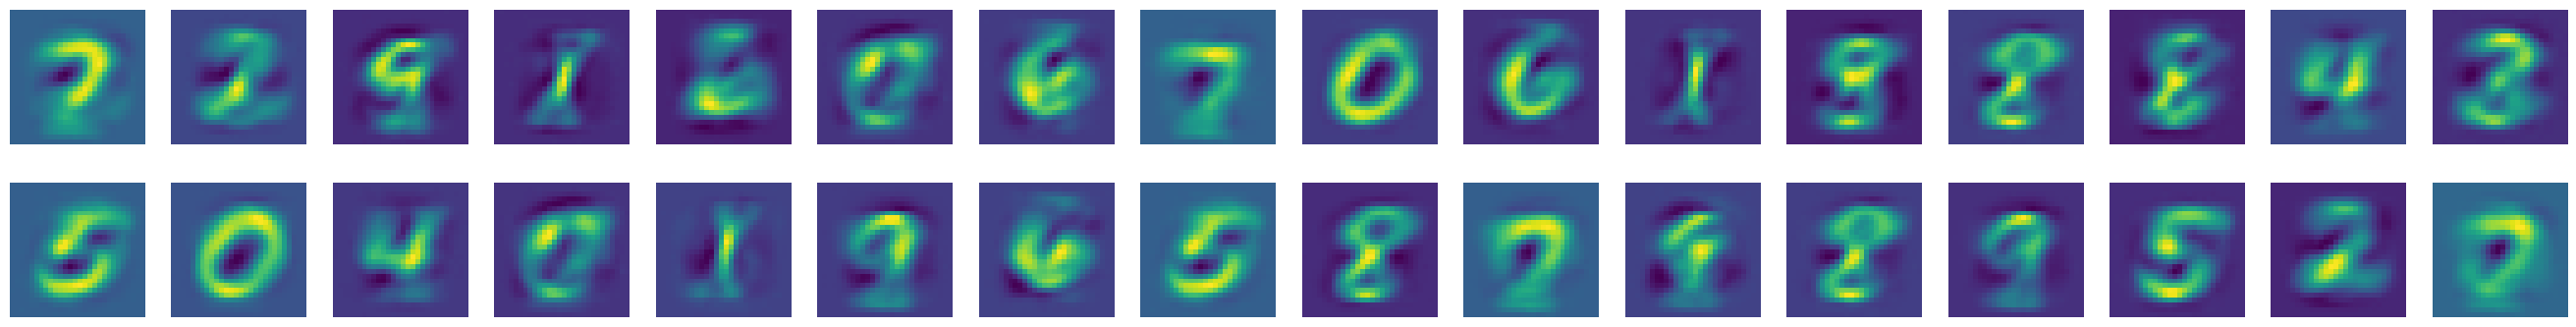

In [11]:
print("Some weights after training")
W = model.state_dict()['l1.weights']
plot_weights(weights=W, nrows=2, ncols=16)

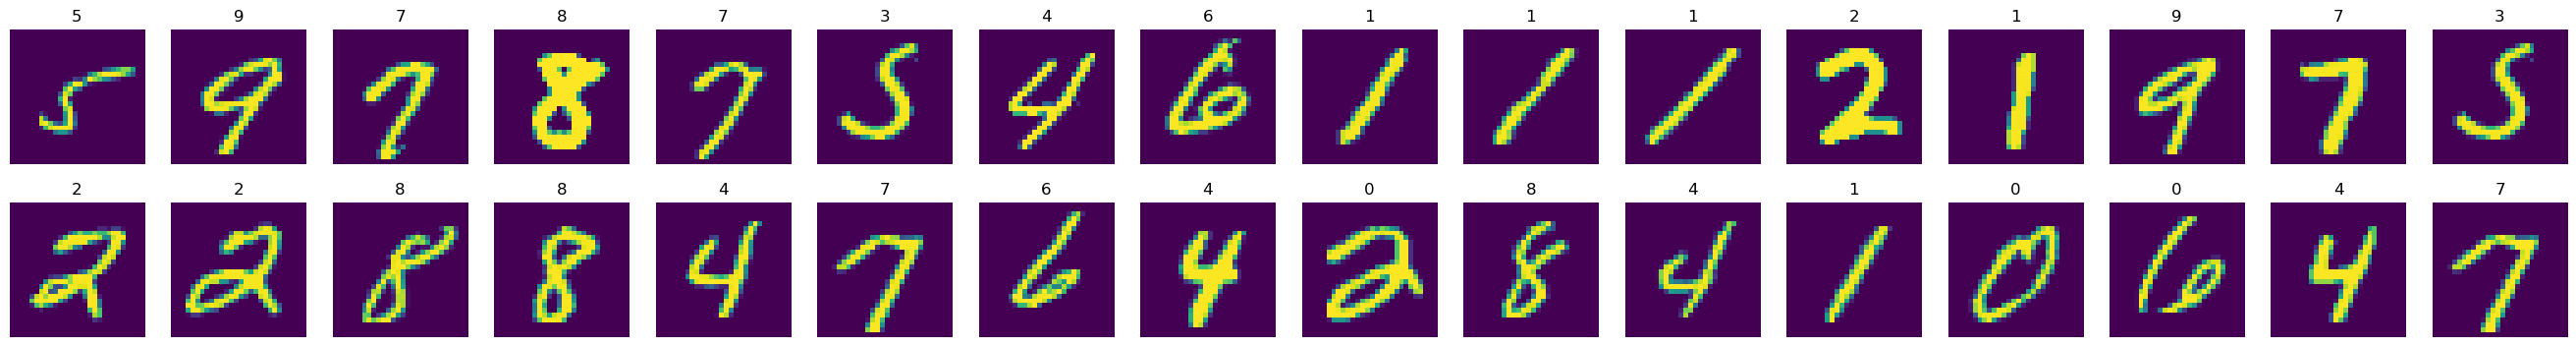

In [13]:
plot_weights(weights=images, nrows=2, ncols=16, suptitle=None, predictions=predicted.numpy())